In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
import networkx as nx
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import init, mcoe, analysis, constants, settings, outputs
from scipy import stats

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
# What is this chained_assignment thing all about?
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [3]:
hwe_out = outputs.PudlOutput(freq=None,
                              start_date='2009-01-01',
                              end_date='2016-12-31',
                              testing=False)
hwe_out.frc_eia923().to_csv(os.path.join(settings.PUDL_DIR, 'results', 'notebooks', 'headwaters', 'HWE_frc_eia923.csv'),index=False)
hwe_out.gens_eia860().to_csv(os.path.join(settings.PUDL_DIR, 'results', 'notebooks', 'headwaters', 'HWE_gens_eia860.csv'), index=False)

In [8]:
nx.__version__

'2.0'

In [7]:
len(hwe_out.plants_eia860().operator_name.unique())

5194

In [236]:
# Setup the initial inputs:
start_date = '2009-01-01'
end_date = '2016-12-31'
freq = 'MS'
testing = False
debug = True
min_heat_rate = 5.5
min_cap_fact = 0.0
max_cap_fact = 1.5

pudl_out = outputs.PudlOutput(freq=freq,
                              start_date=start_date,
                              end_date=end_date,
                              testing=testing)

mcoe_out = pudl_out.mcoe(min_heat_rate=min_heat_rate,
                         min_cap_fact=min_cap_fact,
                         max_cap_fact=max_cap_fact,
                         min_fuel_cost_per_mwh=None, update=True)

plant_id_eia  unit_id_pudl
1004          3                         [1, CT1]
1904          1                     [HBR0, BDS0]
1927          2                     [RIV0, HBR0]
4040          1                     [PWG1, PWG2]
10725         1                     [F801, F802]
50973         1               [BLK1, BLK2, BLK3]
55153         1                     [STG1, STG2]
55309         1                     [SMR1, SMR2]
55502         1                 [CC1, G801, CC2]
56041         1                       [NGS, MGS]
56350         1                      [BLK1, 115]
              2                      [BLK2, 116]
56998         1                        [43, PB4]
              2                        [53, PB5]
Name: unit_code, dtype: object


In [250]:
def hr_hist(mcoe_out, start_date, end_date,
            min_heat_rate=5.5, min_cap_fact=0.0, max_cap_fact=1.5):
    hr_good = mcoe_out[(mcoe_out.heat_rate_mmbtu_mwh >= min_heat_rate) &
                       (mcoe_out.report_date >= pd.to_datetime(start_date)) &
                       (mcoe_out.report_date < pd.to_datetime(end_date)) &
                       (mcoe_out.capacity_factor >= min_cap_fact) &
                       (mcoe_out.capacity_factor <= max_cap_fact)]
    hr_coal = hr_good[(hr_good.fuel_type_pudl=='coal')]
    hr_gas = hr_good[(hr_good.fuel_type_pudl=='gas')]
    plt.figure(figsize=(10,6))
    #plt.hist(hr_coal.heat_rate_mmbtu_mwh, weights=hr_coal.net_generation_mwh, bins=200, range=(5,15), label='Coal')
    #plt.hist(hr_gas.heat_rate_mmbtu_mwh, weights=hr_gas.net_generation_mwh, bins=200, range=(5,15), label='Gas', alpha=0.7)
    plt.hist(hr_coal.heat_rate_mmbtu_mwh, bins=200, range=(5,15), label='Coal')
    plt.hist(hr_gas.heat_rate_mmbtu_mwh, bins=200, range=(5,15), label='Gas', alpha=0.7)
    plt.legend()
    plt.xlabel('Heat rate (mmBTU / MWh)')
    plt.ylabel('MWh Generated')
    min_yr = hr_good.report_date.dt.year.min()
    max_yr = hr_good.report_date.dt.year.max()
    plt.title('Heat Rate by Generator ({}-{})'.format(min_yr, max_yr))
    plt.show();

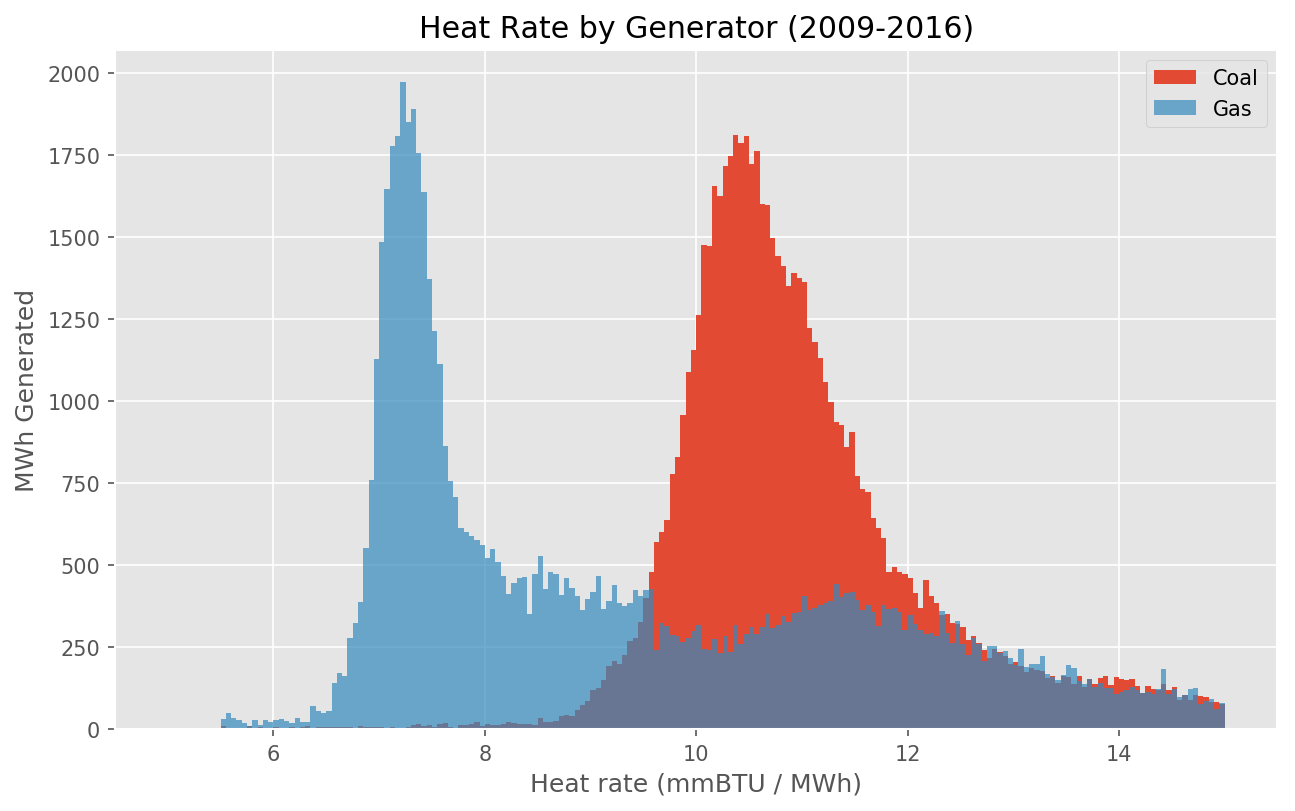

In [251]:
hr_hist(mcoe_out, start_date=start_date, end_date=end_date,
        min_heat_rate=min_heat_rate, min_cap_fact=min_cap_fact, max_cap_fact=max_cap_fact)

In [247]:
int(3.5)

3

In [248]:
def weight_array(ar, weights):
     zipped = zip(ar, weights)
     weighted = []
     for i in zipped:
         for j in range(int(i[1])):
             weighted.append(i[0])
     return weighted

In [ ]:
np.percentile(weight_array(ar, weights), 25)

In [249]:
hr_gas = mcoe_out[mcoe_out.fuel_type_pudl=='gas']
hr_gas_weighted = weight_array(hr_gas.heat_rate_mmbtu_mwh, hr_gas.net_generation_mwh)
hr_coal = mcoe_out[mcoe_out.fuel_type_pudl=='coal']
hr_coal_weighted = weight_array(hr_coal.heat_rate_mmbtu_mwh, hr_coal.net_generation_mwh)
print('Gas, lower: {}'.format(stats.percentileofscore(hr_gas_weighted, 6.5)))
print('Gas, upper: {}'.format(stats.percentileofscore(hr_gas_weighted, 10.0)))
print('Coal, lower: {}'.format(stats.percentileofscore(hr_coal_weighted, 9.0)))
print('Coal, upper: {}'.format(stats.percentileofscore(hr_coal_weighted, 12.0)))

KeyboardInterrupt: 

In [ ]:
stats.percentileofscore()

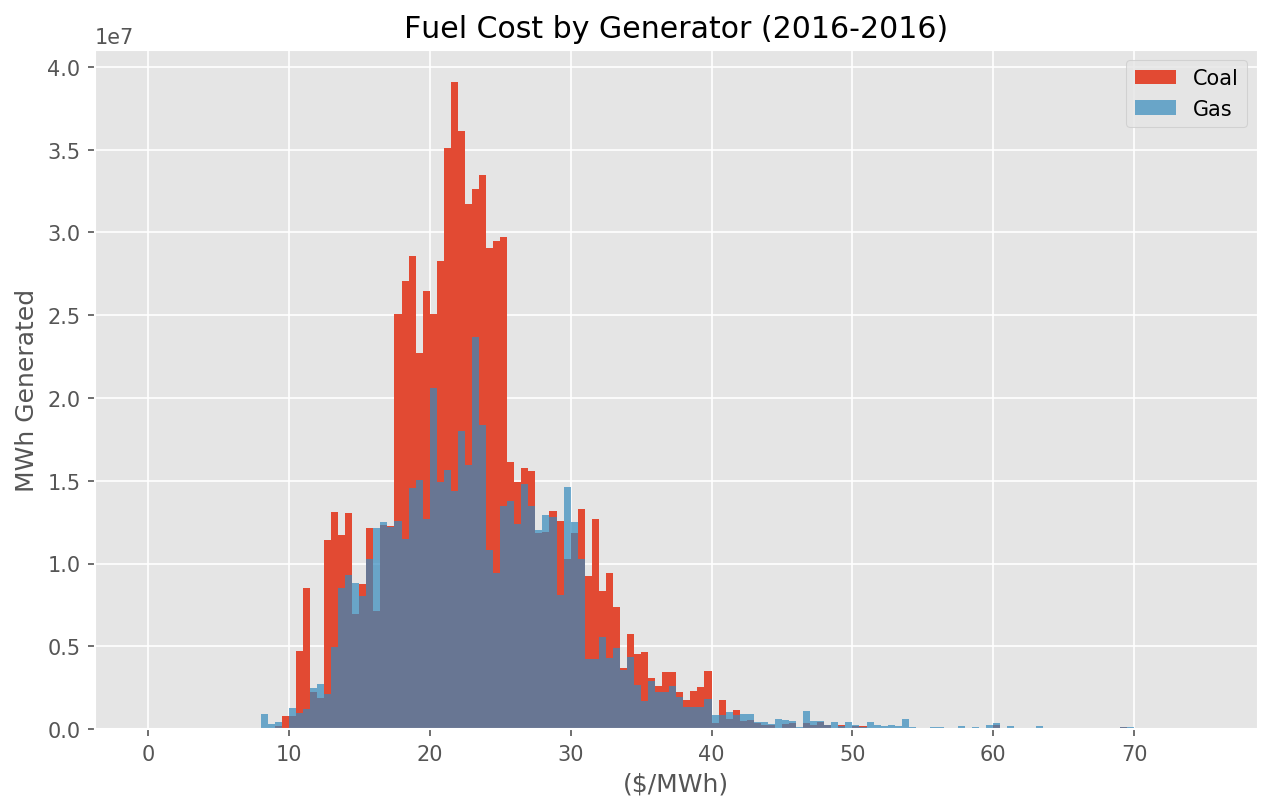

In [6]:
fc_good = mcoe_out.dropna(subset=['fuel_cost_per_mwh','net_generation_mwh'])
fc_good = fc_good[fc_good.heat_rate_mmbtu_mwh >= min_heat_rate]
fc_good = fc_good[fc_good.capacity_factor >= 0.0]
#fc_good = fc_good[fc_good.fuel_cost_per_mwh > 0.0]
fc_coal = fc_good[(fc_good.fuel_type_pudl=='coal')]
fc_gas = fc_good[(fc_good.fuel_type_pudl=='gas')]
plt.figure(figsize=(10,6))
plt.hist(fc_coal.fuel_cost_per_mwh, weights=fc_coal.net_generation_mwh, range=(0,75), bins=150, label='Coal')
plt.hist(fc_gas.fuel_cost_per_mwh, weights=fc_gas.net_generation_mwh, range=(0,75), bins=150, label='Gas', alpha=0.7)
plt.legend()
plt.xlabel('($/MWh)')
plt.ylabel('MWh Generated')
min_yr = fc_good.report_date.dt.year.min()
max_yr = fc_good.report_date.dt.year.max()
plt.title('Fuel Cost by Generator ({}-{})'.format(min_yr, max_yr))
plt.show();

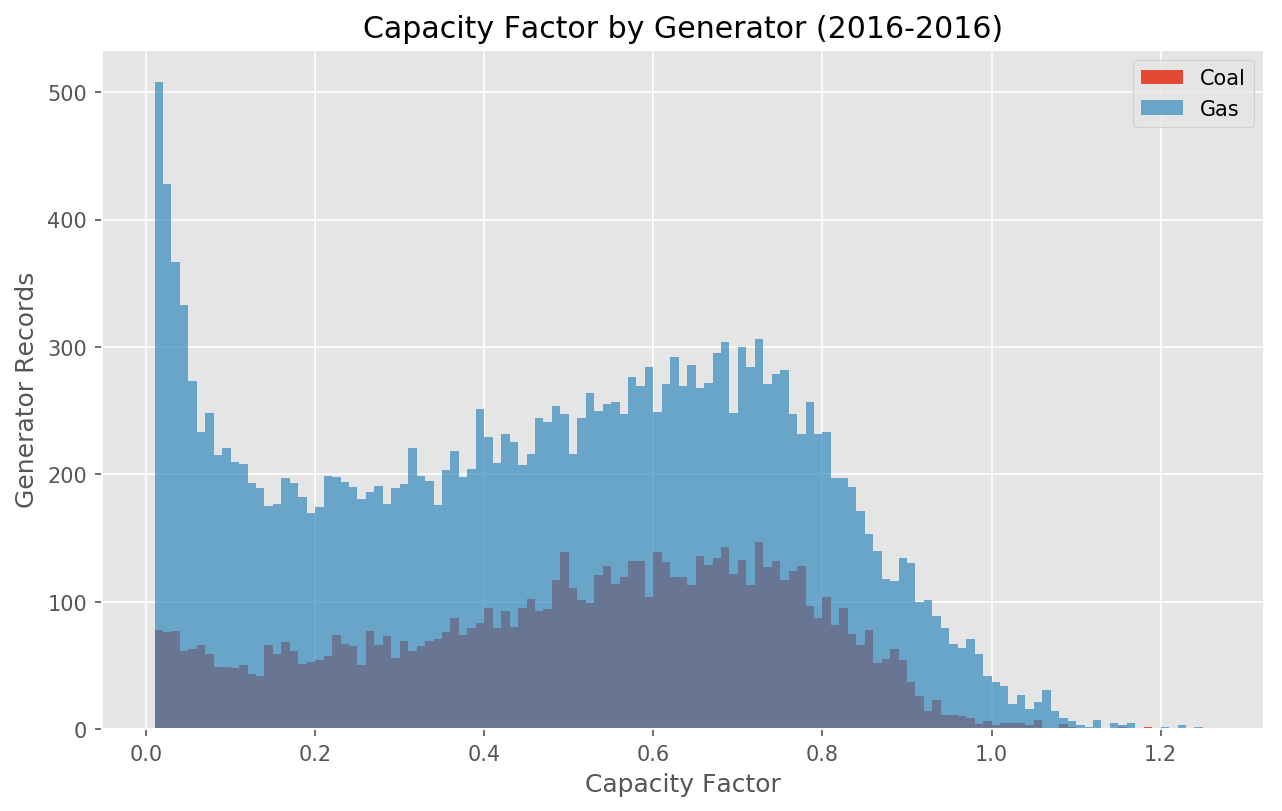

In [7]:
cf_good = mcoe_out[['report_date', 'plant_id_eia', 'generator_id', 'fuel_type_pudl', 'capacity_factor']]
cf_good = cf_good.dropna()
cf_coal = cf_good[(cf_good.fuel_type_pudl=='coal')]
cf_gas = cf_good[(cf_good.fuel_type_pudl=='gas')]
plt.figure(figsize=(10,6))
#plt.hist([cf_gas.capacity_factor, cf_coal.capacity_factor], range=(0.01,1.26), bins=125, stacked=True, label=["Gas","Coal"])
plt.hist(cf_coal.capacity_factor, range=(0.01,1.26), bins=125, label="Coal")
plt.hist(cf_gas.capacity_factor, range=(0.01,1.26), bins=125, alpha=0.7, label="Gas")
plt.ylabel('Generator Records')
plt.xlabel('Capacity Factor')
min_yr = cf_good.report_date.dt.year.min()
max_yr = cf_good.report_date.dt.year.max()
plt.title('Capacity Factor by Generator ({}-{})'.format(min_yr, max_yr))
plt.legend()
plt.show();

In [8]:
simple_cols = [
    'report_date',
    'plant_id_eia',
    'unit_id_pudl',
    'generator_id',
    'operator_name',
    'plant_name',
    'capacity_factor',
    'fuel_cost_per_mmbtu',
    'fuel_cost_per_mwh',
    'fuel_type_count',
    'fuel_type_pudl',
    'heat_rate_mmbtu_mwh',
    'nameplate_capacity_mw',
    'capacity_factor',
    'total_mmbtu',
]
mcoe_simple = mcoe_out[simple_cols]

In [9]:
len(mcoe_simple)

37975

##  Refine our base dataframes
* Make sure all the dataframes have `unit_id_pudl` & `fuel_type_pudl`
* Filter out boilers & generators that are not gas or coal fired for simplicity.

In [10]:
gens_simple = pudl_out.gens_eia860()[['report_date','plant_id_eia','generator_id','fuel_type_pudl']]
bga_gens = pudl_out.bga().drop(['boiler_id','unit_code','bga_source'], axis=1).drop_duplicates()
bga_boils = pudl_out.bga().drop(['generator_id','unit_code','bga_source'], axis=1).drop_duplicates()
gens_simple = pd.merge(gens_simple, bga_gens,
                       on=['report_date','plant_id_eia','generator_id'],
                       validate='one_to_one')

gen_eia923_cg = analysis.merge_on_date_year(pudl_out.gen_eia923(), gens_simple,
                                            on=['plant_id_eia','generator_id'],
                                            how='left')
gen_eia923_cg = gen_eia923_cg[gen_eia923_cg.fuel_type_pudl.isin(['gas','coal'])]

bf_eia923_cg = analysis.merge_on_date_year(pudl_out.bf_eia923(), bga_boils,
                                           on=['plant_id_eia','boiler_id'])
bf_eia923_cg = bf_eia923_cg[bf_eia923_cg.fuel_type_pudl.isin(['gas','coal'])]

frc_eia923_cg = pudl_out.frc_eia923()[pudl_out.frc_eia923().fuel_type_pudl.isin(['gas','coal'])]

mcoe_cg = mcoe_out[mcoe_out.fuel_type_pudl.isin(['gas','coal'])]

In [11]:
def mcoe_corr(before, after, x_max, y_max, r_max,
              xlabel='', ylabel='', title='', labels=[],
              alpha=0.5, s=3, loghist=True):
    
    plt.figure(figsize=(8,8))
    
    for b, a, l in zip(before, after, labels):
        plt.scatter(b, a, s=s, alpha=alpha, label=l)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(-x_max/20,x_max)
    plt.ylim(-y_max/20,y_max)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8,2))
    for b, a in zip(before, after):
        ratio = a/b
        plt.hist(ratio.dropna(), range=(0,r_max), bins=200, log=loghist, alpha=0.5)
    plt.xlim(0,r_max)
    plt.title('Ratio of reported to MCOE values')
    plt.show()

## Net Generation: EIA923 vs. MCOE
Net generation is reported on a per-generator basis, and we never transform it, so the quantities that show up in the MCOE output should match the inputs exactly.

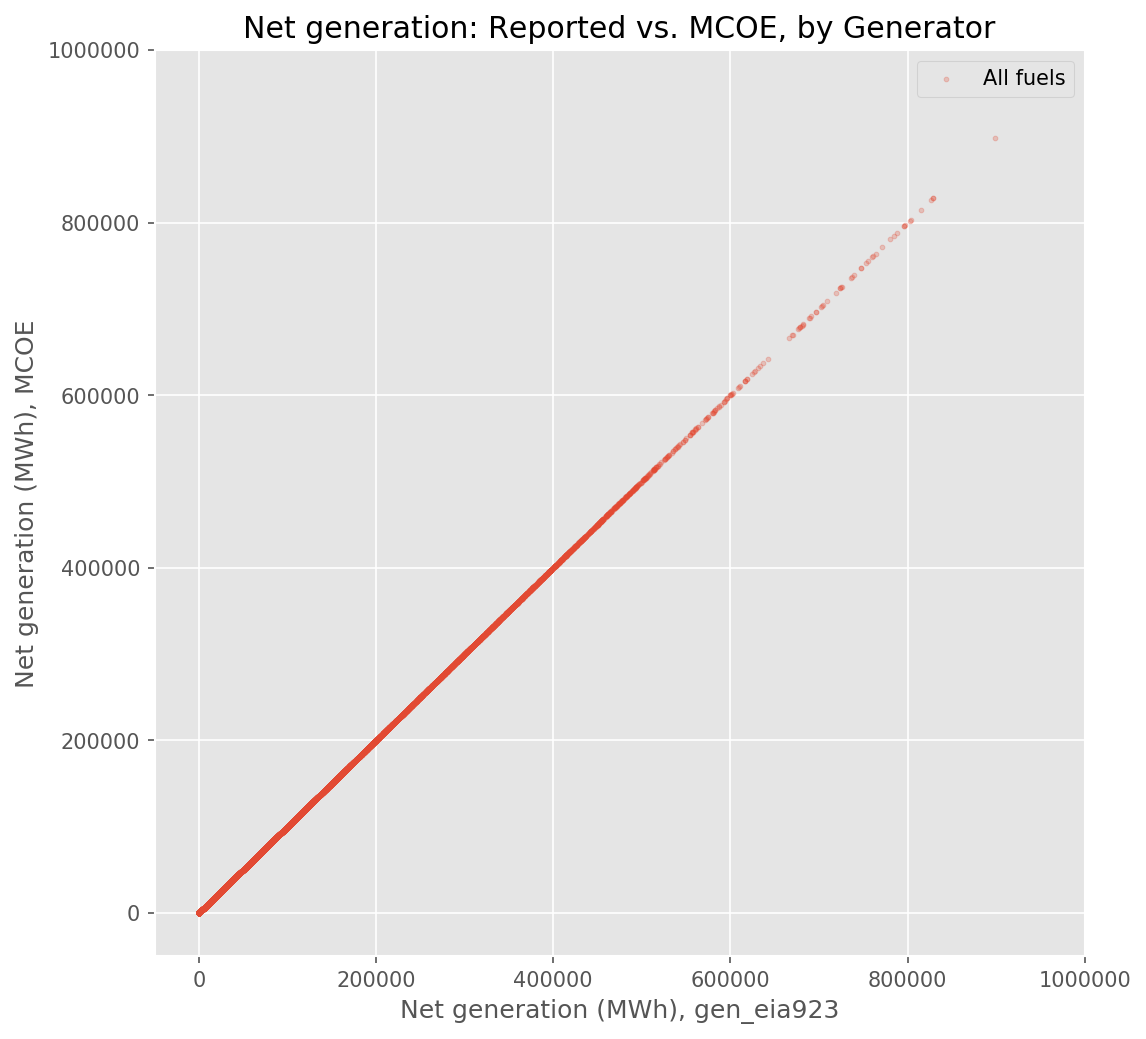

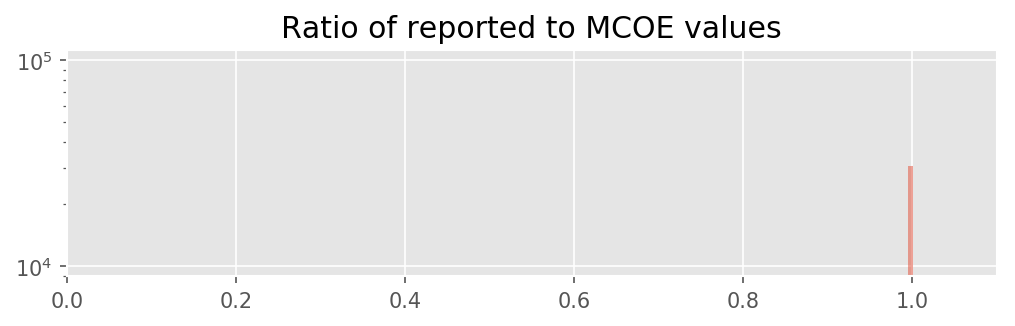

In [12]:
gen_generator_compare = pd.merge(
    mcoe_cg[['report_date','plant_id_eia','generator_id','net_generation_mwh']],
    gen_eia923_cg[['report_date','plant_id_eia','generator_id','net_generation_mwh']],
    on=['report_date','plant_id_eia','generator_id'],
    suffixes=['_mcoe','_eia923'],
    validate='one_to_one'
)

mcoe_corr([gen_generator_compare.net_generation_mwh_eia923],
          [gen_generator_compare.net_generation_mwh_mcoe],
          x_max=1e6, y_max=1e6, r_max=1.1, alpha=0.25, s=5, loghist=True,
          xlabel='Net generation (MWh), gen_eia923',
          ylabel='Net generation (MWh), MCOE',
          title='Net generation: Reported vs. MCOE, by Generator',
          labels=['All fuels'])

## Net Generation: EIA923 vs. MCOE (by Generation Unit)
In calculating the net generation on a per generation unit basis, all we're doing is adding up all the generation from the individual generators that make up a unit.  So long as the unit-to-generator mapping is self consistent, this should also match up exactly, since we're not transforming the net generation.

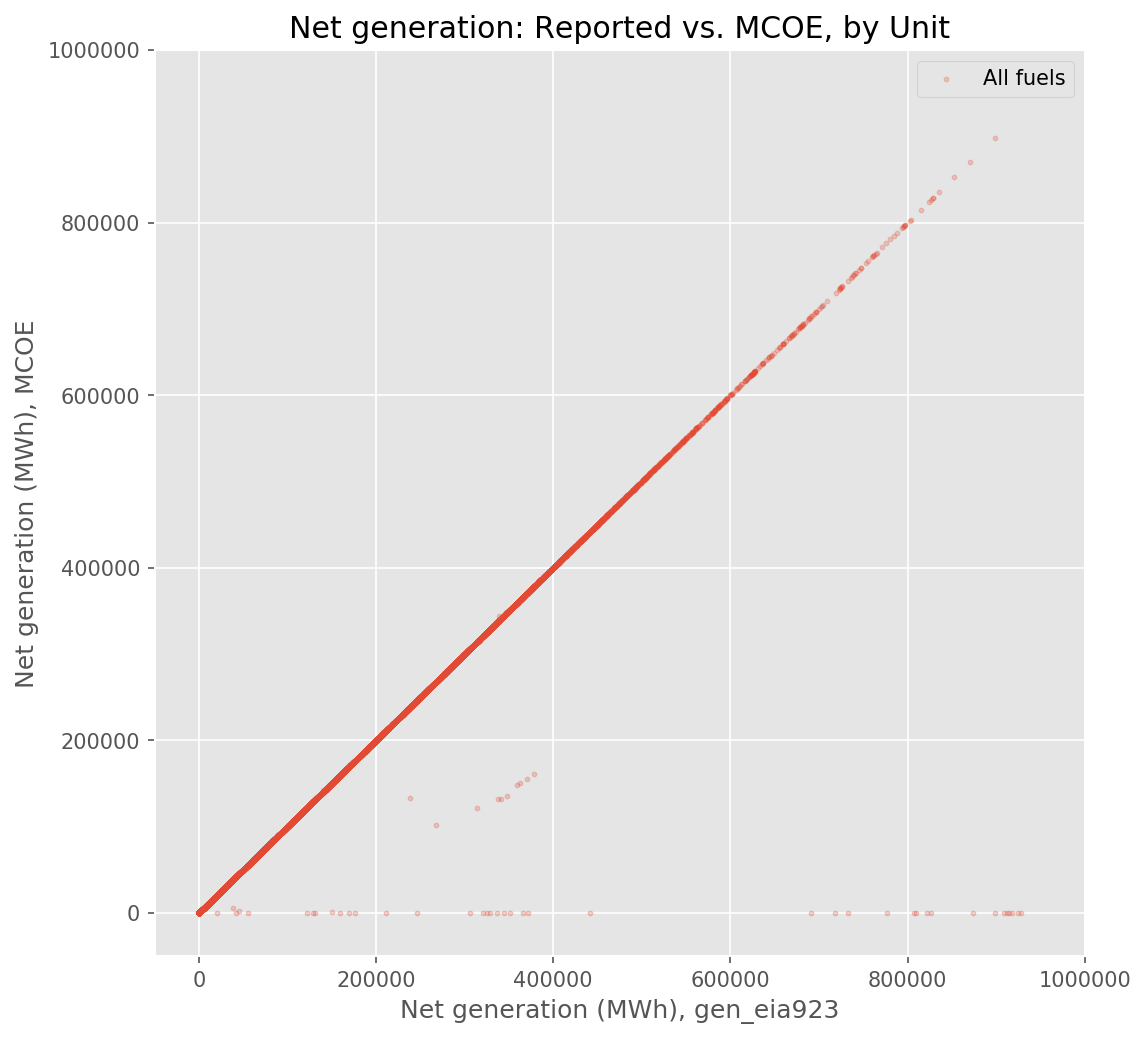

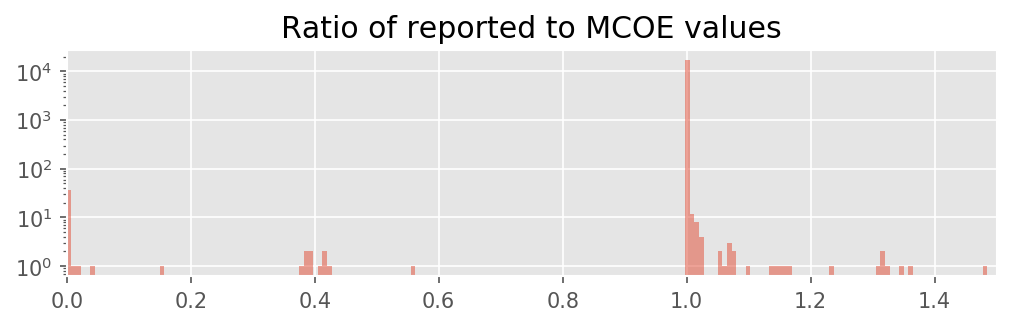

In [13]:
before = gen_eia923_cg.groupby(['report_date', 'plant_id_eia', 'unit_id_pudl'])['net_generation_mwh'].sum().reset_index()
after = mcoe_cg.groupby(['report_date', 'plant_id_eia', 'unit_id_pudl'])['net_generation_mwh'].sum().reset_index()

gen_unit_compare = pd.merge(
    before[['report_date','plant_id_eia','unit_id_pudl','net_generation_mwh']],
    after[['report_date','plant_id_eia','unit_id_pudl','net_generation_mwh']],
    on=['report_date','plant_id_eia','unit_id_pudl'],
    suffixes=['_eia923','_mcoe'],
    validate='one_to_one'
)

mcoe_corr([gen_unit_compare.net_generation_mwh_eia923],
          [gen_unit_compare.net_generation_mwh_mcoe],
          x_max=1e6, y_max=1e6, r_max=1.5, s=5, alpha=0.25, loghist=True,
          xlabel='Net generation (MWh), gen_eia923',
          ylabel='Net generation (MWh), MCOE',
          title='Net generation: Reported vs. MCOE, by Unit',
          labels=['All fuels'])

## Net Generation, EIA923 vs. MCOE (by Plant)
When we aggregate the net generation at the plant level, we end up with a tiny mismatch. I suspect this is because there are some plants in which there are bad units or generator records within the MCOE output, so the plant level data gets kept, but only a portion of the generator or unit level net generation shows up in the MCOE output.

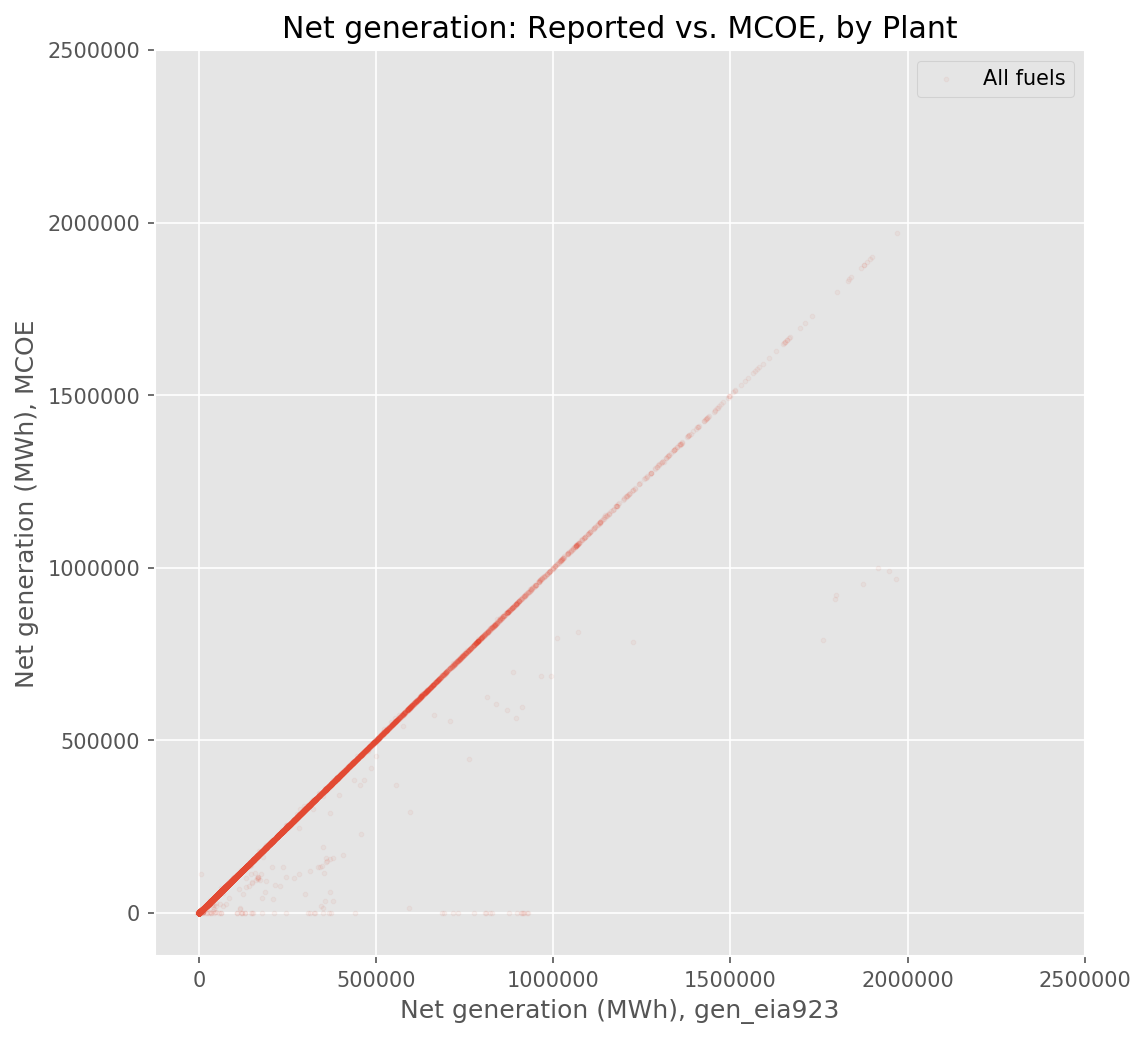

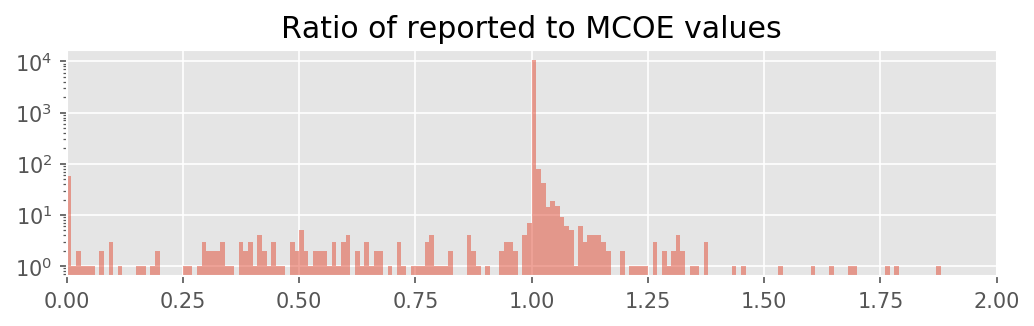

In [14]:
before = gen_eia923_cg.groupby(['report_date', 'plant_id_eia'])['net_generation_mwh'].sum().reset_index()
after = mcoe_cg.groupby(['report_date', 'plant_id_eia'])['net_generation_mwh'].sum().reset_index()

gen_plant_compare = pd.merge(
    before[['report_date','plant_id_eia','net_generation_mwh']],
    after[['report_date','plant_id_eia','net_generation_mwh']],
    on=['report_date','plant_id_eia'],
    suffixes=['_eia923','_mcoe'],
    validate='one_to_one'
)

mcoe_corr([gen_plant_compare.net_generation_mwh_eia923],
          [gen_plant_compare.net_generation_mwh_mcoe],
          x_max=2.5e6, y_max=2.5e6, r_max=2, alpha=0.05, s=5, loghist=True,
          xlabel='Net generation (MWh), gen_eia923',
          ylabel='Net generation (MWh), MCOE',
          title='Net generation: Reported vs. MCOE, by Plant',
          labels=['All fuels'])

## Fuel consumed: EIA923 vs. MCOE (by Unit)
Aggregating the original boiler fuel consumption data by generation unit and comparing that to the calculated fuel consumption in the MCOE output gives us a bigger spread. The per-unit fuel consumption in the MCOE output is derived from the calctulated per-unit heat rate and the per-unit net generation.  Because the reported boiler fuel consumption is gross -- the total fuel consumed -- and the electricity generation is net output, after parasitic loads of the plant are accounted for, these end up being a little bit of a mismatch.

In theory, we could account for this parasitic fuel consumption at the plant level by using data from the generation_fuel_eia923 table, which indicates how much fuel was consumed for generation vs. non-generation, but in practice we care more about the effective heat rate and gross fuel consumption per net unit of electricity delivered to the grid, so for now we're not using the generation_fuel_eia923 information.

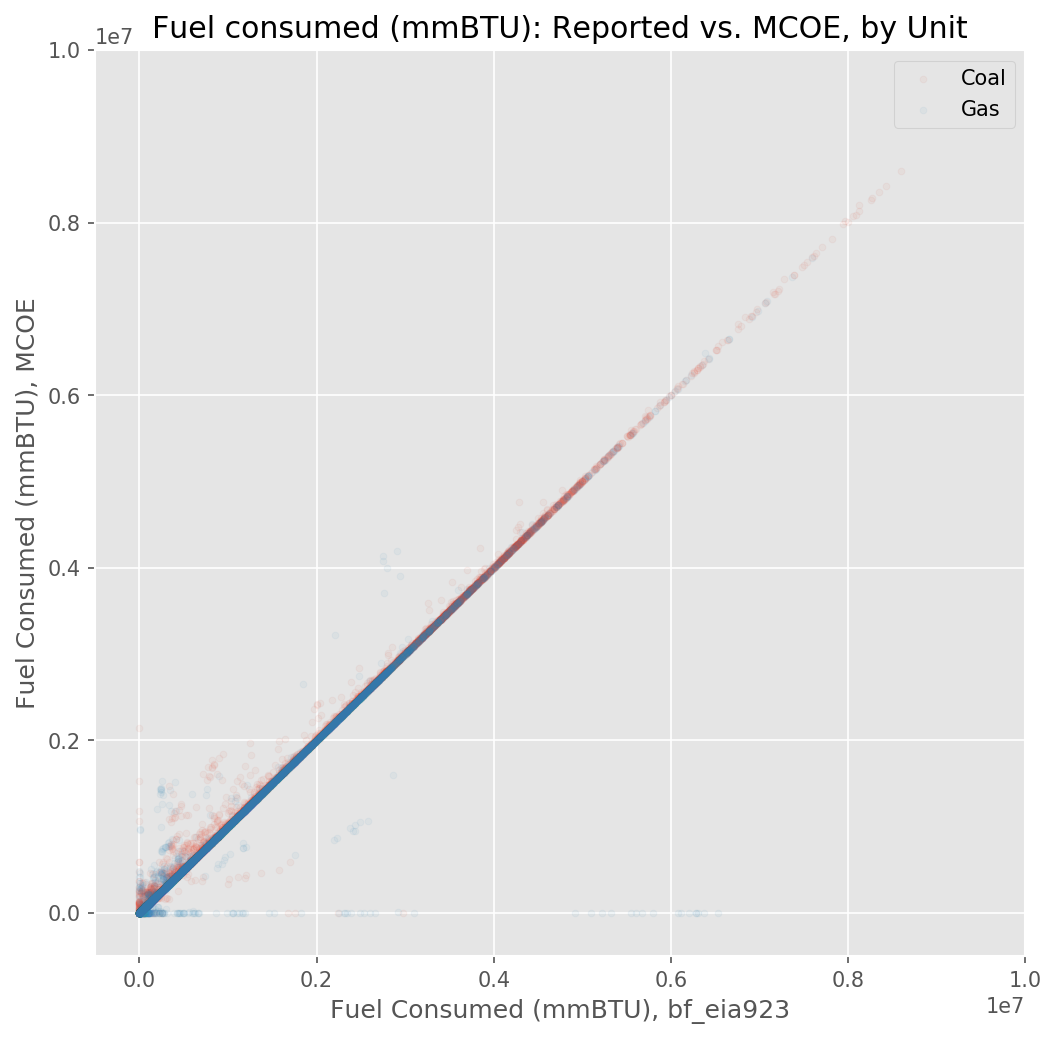

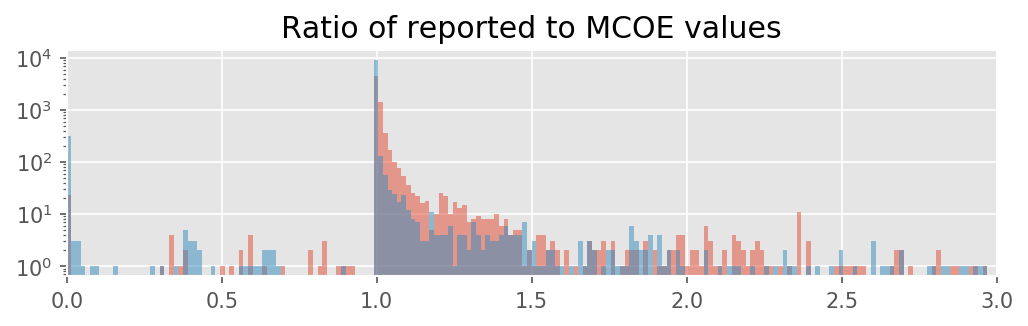

In [15]:
years = [2009,2010,2011,2012,2013,2014,2015,2016]
#years = [2009,2010,2011,2012,2013,2014]
#years = [2013,2014,2015,2016]
before = bf_eia923_cg.groupby(['report_date', 'plant_id_eia', 'unit_id_pudl', 'fuel_type_pudl'])['total_heat_content_mmbtu'].sum().reset_index()
before = before.rename(columns={'total_heat_content_mmbtu': 'total_mmbtu'})
before = before[before.report_date.dt.year.isin(years)]
after = mcoe_cg.groupby(['report_date', 'plant_id_eia', 'unit_id_pudl','fuel_type_pudl'])['total_mmbtu'].sum().reset_index()
after = after[after.report_date.dt.year.isin(years)]

mmbtu_unit_compare = pd.merge(
    before[['report_date','plant_id_eia','unit_id_pudl','fuel_type_pudl','total_mmbtu']],
    after[['report_date','plant_id_eia','unit_id_pudl','fuel_type_pudl','total_mmbtu']],
    on=['report_date','plant_id_eia','unit_id_pudl', 'fuel_type_pudl'],
    suffixes=['_eia923','_mcoe'],
    validate='one_to_one'
)

mcoe_corr([mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='coal'].total_mmbtu_eia923,
           mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='gas'].total_mmbtu_eia923],
          [mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='coal'].total_mmbtu_mcoe,
           mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='gas'].total_mmbtu_mcoe],
          x_max=1.0e7, y_max=1.0e7, r_max=3, alpha=0.05, s=10, loghist=True,
          xlabel='Fuel Consumed (mmBTU), bf_eia923',
          ylabel='Fuel Consumed (mmBTU), MCOE',
          title='Fuel consumed (mmBTU): Reported vs. MCOE, by Unit',
          labels=['Coal','Gas'])

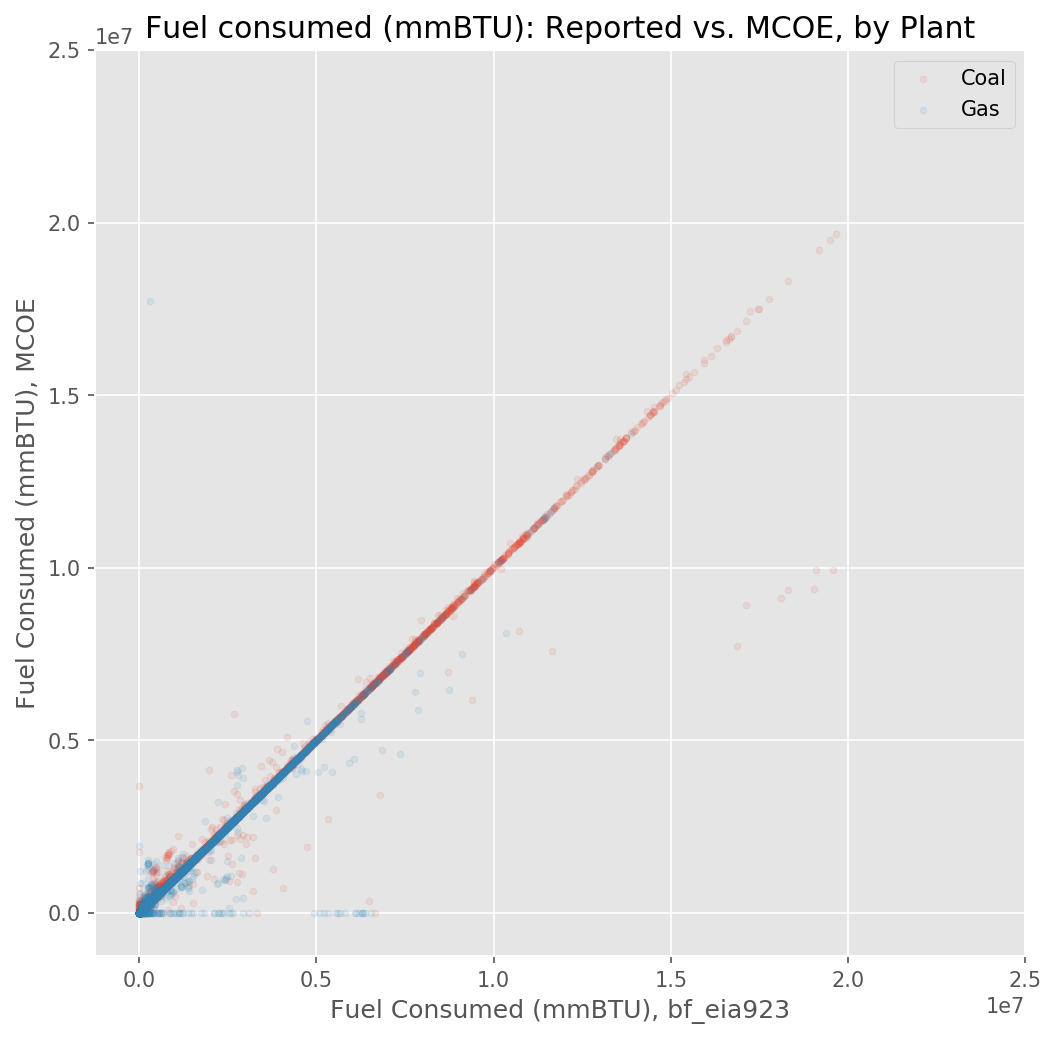

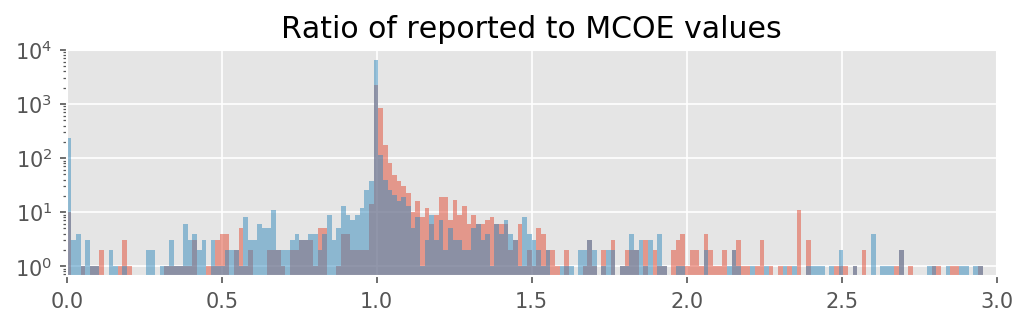

In [16]:
years = [2009,2010,2011,2012,2013,2014,2015,2016]
#years = [2009,2010,2011,2012]
#years = [2015,2016]
before = bf_eia923_cg.groupby(['report_date', 'plant_id_eia','fuel_type_pudl'])['total_heat_content_mmbtu'].sum().reset_index()
before = before.rename(columns={'total_heat_content_mmbtu': 'total_mmbtu'})
before = before[before.report_date.dt.year.isin(years)]
after = mcoe_cg.groupby(['report_date', 'plant_id_eia','fuel_type_pudl'])['total_mmbtu'].sum().reset_index()
after = after[after.report_date.dt.year.isin(years)]

mmbtu_plant_compare = pd.merge(
    before[['report_date','plant_id_eia','fuel_type_pudl','total_mmbtu']],
    after[['report_date','plant_id_eia','fuel_type_pudl','total_mmbtu']],
    on=['report_date','plant_id_eia','fuel_type_pudl'],
    suffixes=['_eia923','_mcoe'],
    validate='one_to_one'
)

mcoe_corr([mmbtu_plant_compare[mmbtu_plant_compare.fuel_type_pudl=='coal'].total_mmbtu_eia923,
           mmbtu_plant_compare[mmbtu_plant_compare.fuel_type_pudl=='gas'].total_mmbtu_eia923],
          [mmbtu_plant_compare[mmbtu_plant_compare.fuel_type_pudl=='coal'].total_mmbtu_mcoe,
           mmbtu_plant_compare[mmbtu_plant_compare.fuel_type_pudl=='gas'].total_mmbtu_mcoe],
          x_max=2.5e7, y_max=2.5e7, r_max=3, alpha=0.1, s=10, loghist=True,
          xlabel='Fuel Consumed (mmBTU), bf_eia923',
          ylabel='Fuel Consumed (mmBTU), MCOE',
          title='Fuel consumed (mmBTU): Reported vs. MCOE, by Plant',
          labels=['Coal','Gas'])

## Delivered vs. Consumed Fuel in EIA923, by Plant
The fuel_receipts_costs_eia923 data reports when fuel is delivered, and how much.  The boiler_fuel_eia923 data reports when fuel is consumed, and how much.  However, before 2015, the combustion turbine portion of combined cycle plants were not reporting their fuel consumption.  At the same time, their fuel deliveries were being reported.  This results in the lobe of gas near the x-axis in the plot below -- where the fuel is reported delivered, but no corresponding (or little corresponding) boiler consumption is reported.

There's also a lag between fuel delivery and consumption, much moreseo for coal than for gas, so we see a big spread in the ratios of the coal, but not so much in the gas.

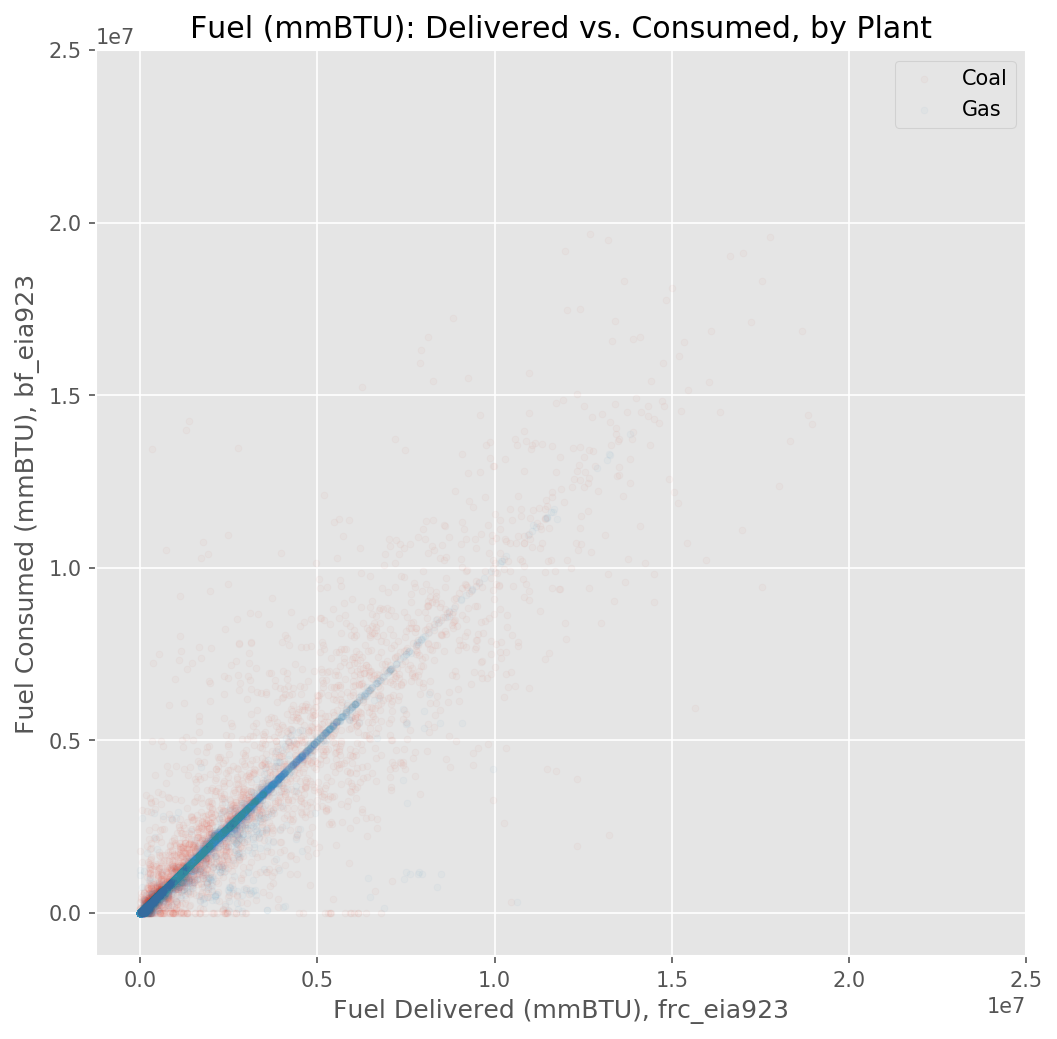

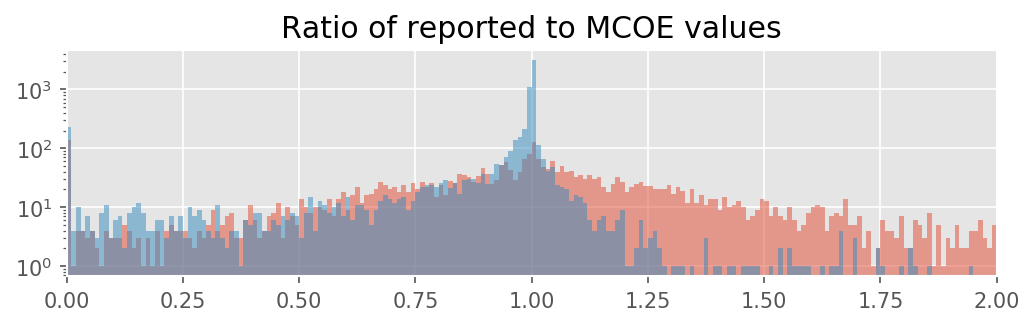

In [17]:
years = [2009,2010,2011,2012,2013,2014,2015,2016]
#years = [2015,2016]
before = frc_eia923_cg.groupby(['report_date', 'plant_id_eia','fuel_type_pudl'])['total_heat_content_mmbtu'].sum().reset_index()
before = before.rename(columns={'total_heat_content_mmbtu': 'total_mmbtu'})
before = before[before.report_date.dt.year.isin(years)]
after = bf_eia923_cg.groupby(['report_date', 'plant_id_eia','fuel_type_pudl'])['total_heat_content_mmbtu'].sum().reset_index()
after = after.rename(columns={'total_heat_content_mmbtu': 'total_mmbtu'})
after = after[after.report_date.dt.year.isin(years)]

mmbtu_unit_compare = pd.merge(
    before[['report_date','plant_id_eia','fuel_type_pudl','total_mmbtu']],
    after[['report_date','plant_id_eia','fuel_type_pudl','total_mmbtu']],
    on=['report_date','plant_id_eia','fuel_type_pudl'],
    suffixes=['_frc','_bf'],
    validate='one_to_one'
)

mcoe_corr([mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='coal'].total_mmbtu_frc,
           mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='gas'].total_mmbtu_frc],
          [mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='coal'].total_mmbtu_bf,
           mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='gas'].total_mmbtu_bf],
          x_max=2.5e7, y_max=2.5e7, r_max=2, alpha=0.03, s=10, loghist=True,
          xlabel='Fuel Delivered (mmBTU), frc_eia923',
          ylabel='Fuel Consumed (mmBTU), bf_eia923',
          title='Fuel (mmBTU): Delivered vs. Consumed, by Plant',
          labels=['Coal','Gas'])

## Recent Gas consumed vs. delivered (Plant Level)
Looking just at the 2015-2016 data, which includes all the combined cycle combustion turbine gas consumption, we get a much cleaner correspondence between delivered and consumed gas.

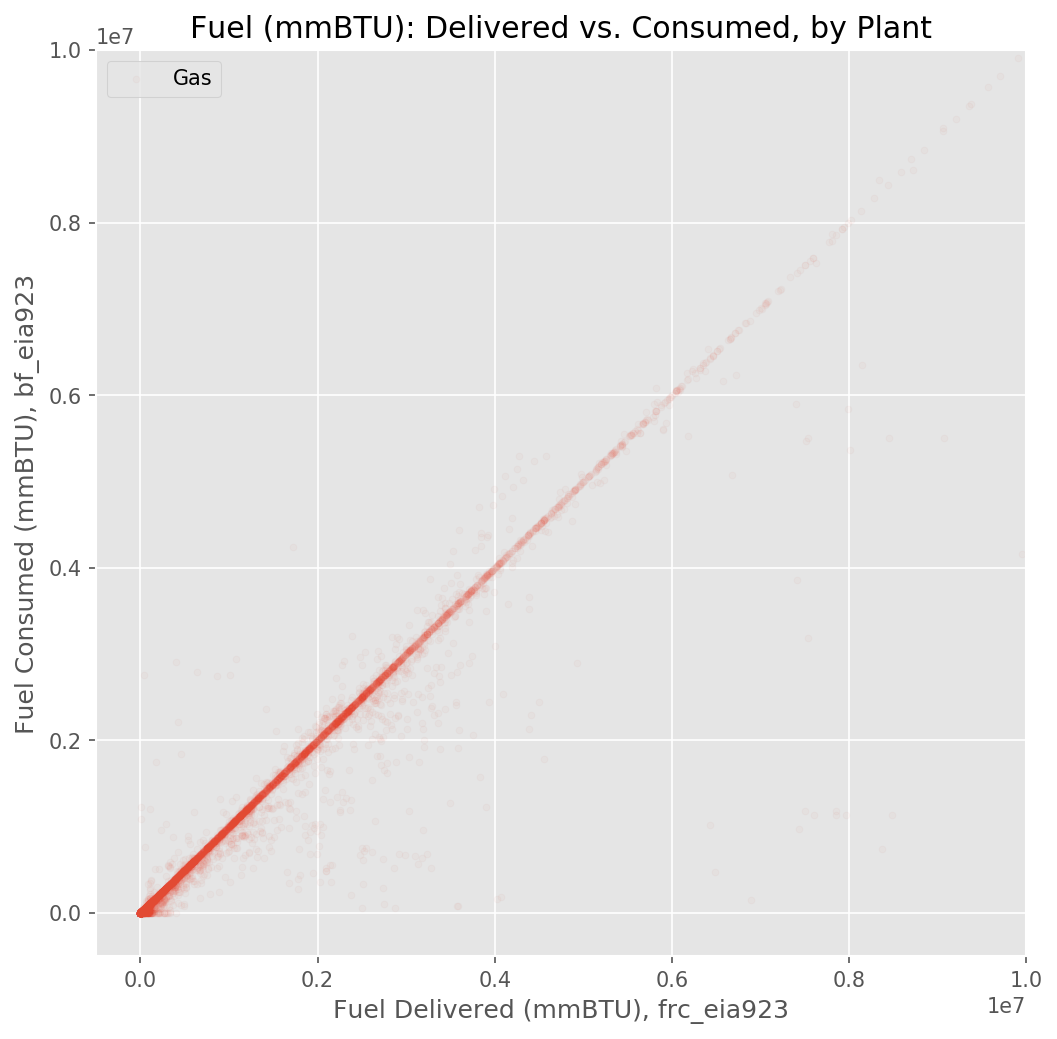

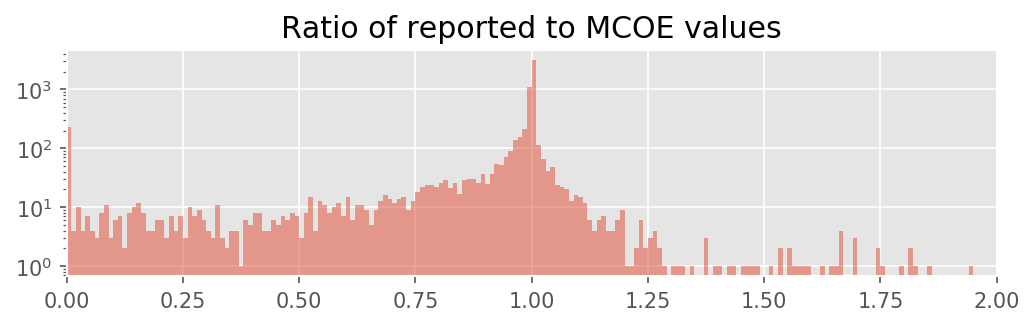

In [18]:
#years = [2009,2010,2011,2012,2013,2014,2015,2016]
years = [2015,2016]
before = frc_eia923_cg.groupby(['report_date', 'plant_id_eia','fuel_type_pudl'])['total_heat_content_mmbtu'].sum().reset_index()
before = before.rename(columns={'total_heat_content_mmbtu': 'total_mmbtu'})
before = before[before.report_date.dt.year.isin(years)]
after = bf_eia923_cg.groupby(['report_date', 'plant_id_eia','fuel_type_pudl'])['total_heat_content_mmbtu'].sum().reset_index()
after = after.rename(columns={'total_heat_content_mmbtu': 'total_mmbtu'})
after = after[after.report_date.dt.year.isin(years)]

mmbtu_unit_compare = pd.merge(
    before[['report_date','plant_id_eia','fuel_type_pudl','total_mmbtu']],
    after[['report_date','plant_id_eia','fuel_type_pudl','total_mmbtu']],
    on=['report_date','plant_id_eia','fuel_type_pudl'],
    suffixes=['_frc','_bf'],
    validate='one_to_one'
)

mcoe_corr([mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='gas'].total_mmbtu_frc],
          [mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='gas'].total_mmbtu_bf],
          x_max=1.0e7, y_max=1.0e7, r_max=2, alpha=0.03, s=10, loghist=True,
          xlabel='Fuel Delivered (mmBTU), frc_eia923',
          ylabel='Fuel Consumed (mmBTU), bf_eia923',
          title='Fuel (mmBTU): Delivered vs. Consumed, by Plant',
          labels=['Gas'])

## EIA923 Fuel Delivered vs. MCOE Fuel Consumed, by Plant
In order to calculate the fuel costs, we need to use the fuel deliveries, but we're attributing those costs based on the fuel consumed by each generation unit, as implied by its heat rate and net generation.  Both the lag between delivery and consumption, and the bad older combined cycle combustion turbine data make this a little messy.

We can only use 2015-2016 data for combined cycle plants, and for coal really need to annualize the data to get a good correspondence between delivered and consumed fuel.

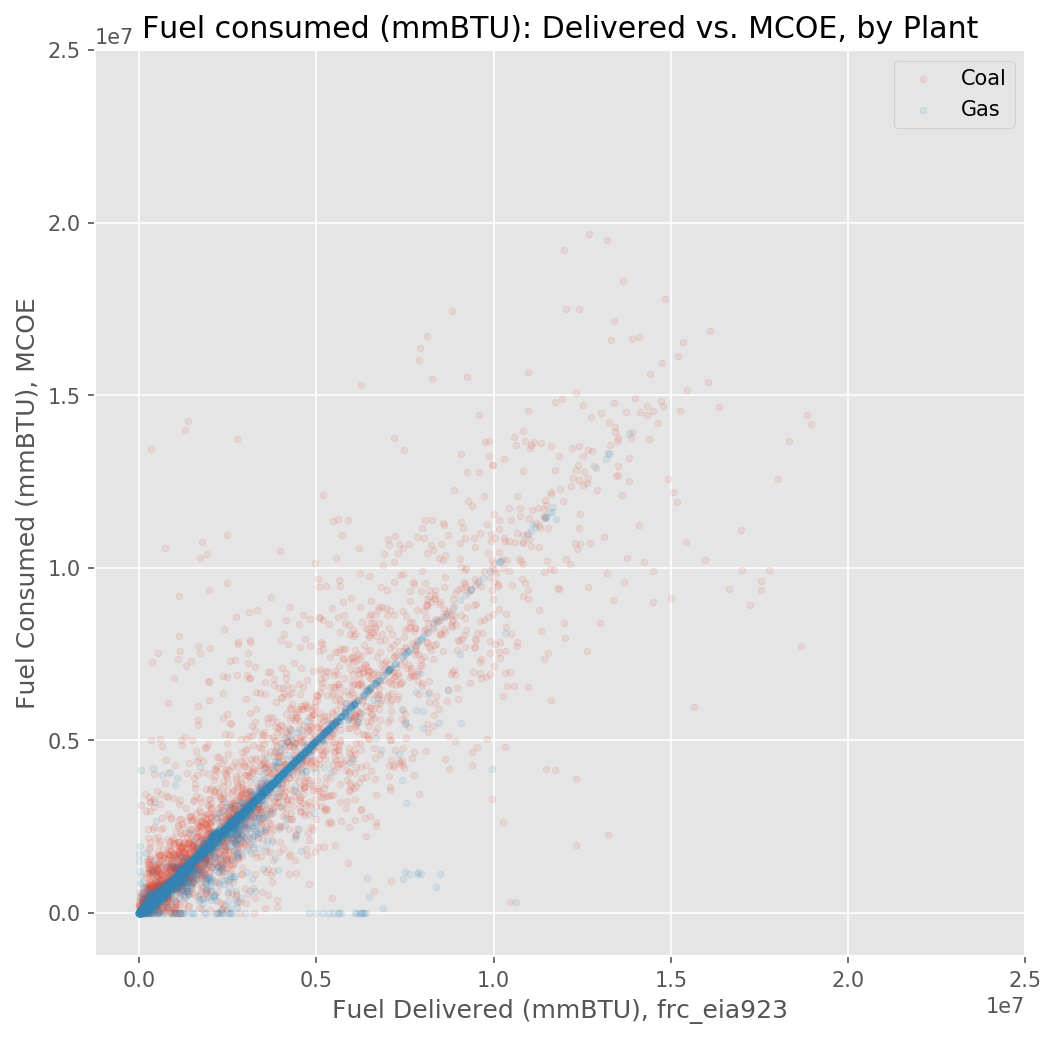

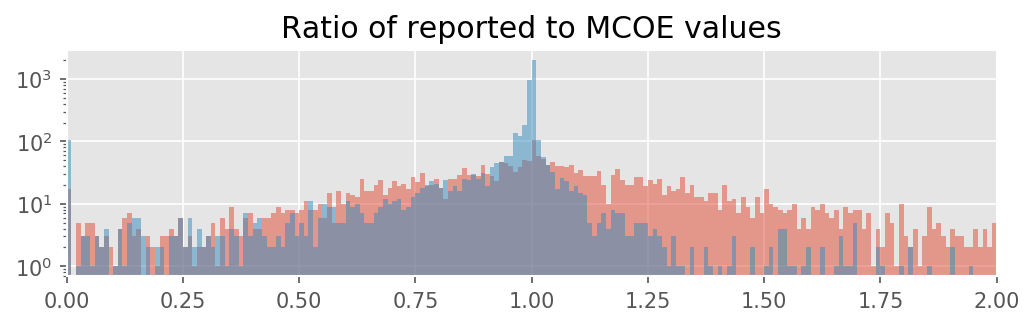

In [19]:
years = [2009,2010,2011,2012,2013,2014,2015,2016]
#years = [2015,2016]
before = frc_eia923_cg.groupby(['report_date', 'plant_id_eia','fuel_type_pudl'])['total_heat_content_mmbtu'].sum().reset_index()
before = before.rename(columns={'total_heat_content_mmbtu': 'total_mmbtu'})
before = before[before.report_date.dt.year.isin(years)]
after = mcoe_cg.groupby(['report_date', 'plant_id_eia','fuel_type_pudl'])['total_mmbtu'].sum().reset_index()
after = after[after.report_date.dt.year.isin(years)]

mmbtu_unit_compare = pd.merge(
    before[['report_date','plant_id_eia','fuel_type_pudl','total_mmbtu']],
    after[['report_date','plant_id_eia','fuel_type_pudl','total_mmbtu']],
    on=['report_date','plant_id_eia','fuel_type_pudl'],
    suffixes=['_eia923','_mcoe'],
    validate='one_to_one'
)

mcoe_corr([mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='coal'].total_mmbtu_eia923,
           mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='gas'].total_mmbtu_eia923],
          [mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='coal'].total_mmbtu_mcoe,
           mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='gas'].total_mmbtu_mcoe],
          x_max=2.5e7, y_max=2.5e7, r_max=2, alpha=0.1, s=10, loghist=True,
          xlabel='Fuel Delivered (mmBTU), frc_eia923',
          ylabel='Fuel Consumed (mmBTU), MCOE',
          title='Fuel consumed (mmBTU): Delivered vs. MCOE, by Plant',
          labels=['Coal','Gas'])

## Delivered (EIA923) vs. Consumed (MCOE) Fuel, 2015-2016 gas only
Looking at just the recent gas data, we get a good correspondence between the delivered and consumed quantities, since there's not much of a time lag between delivery and consumption for gas, and all of the combined cycle gas is included for those most recent years.

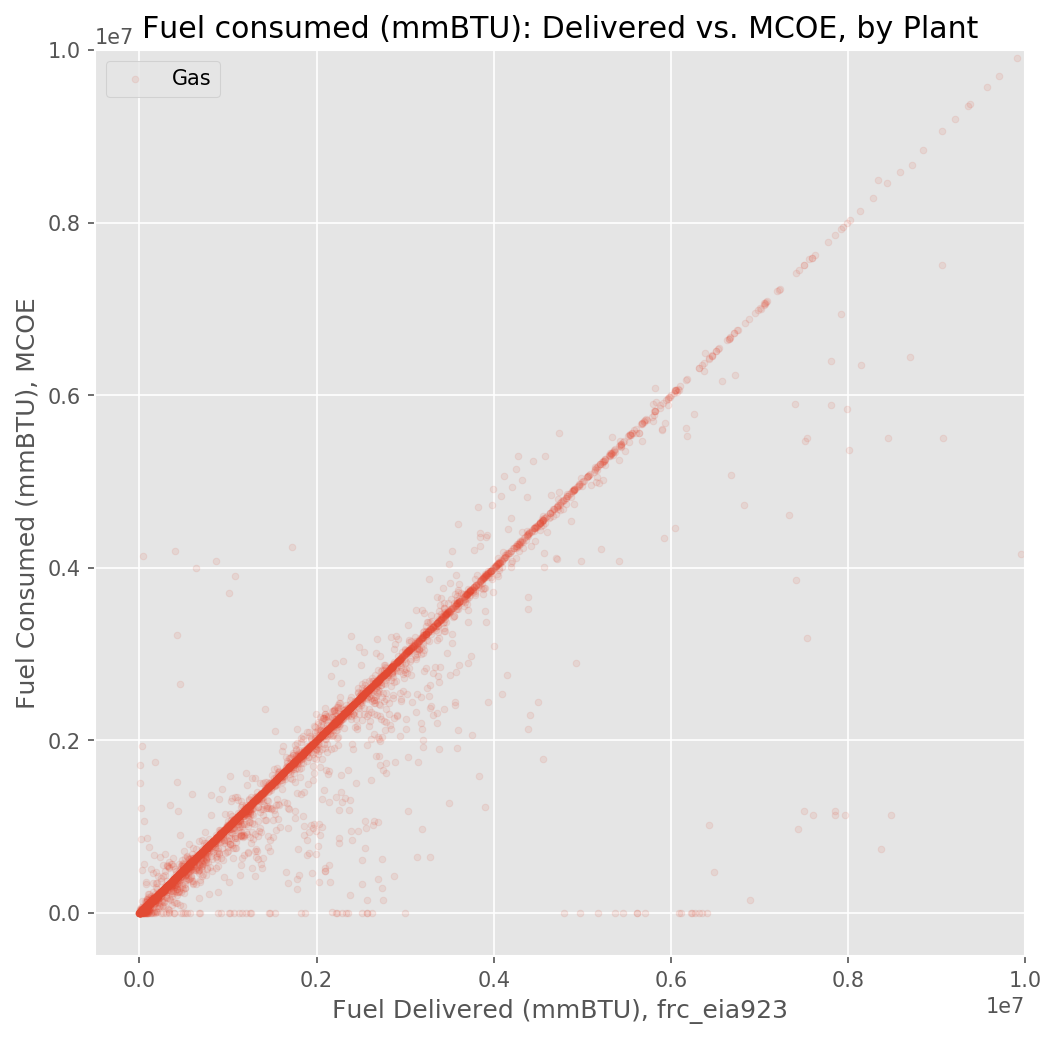

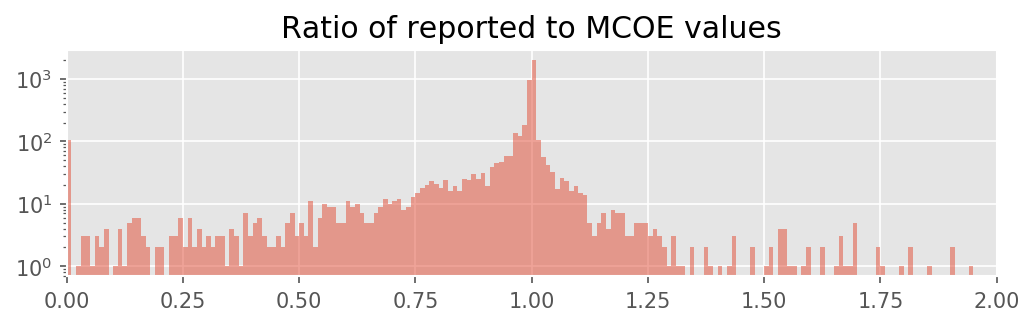

In [20]:
#years = [2009,2010,2011,2012,2013,2014,2015,2016]
years = [2015,2016]
before = frc_eia923_cg.groupby(['report_date', 'plant_id_eia','fuel_type_pudl'])['total_heat_content_mmbtu'].sum().reset_index()
before = before.rename(columns={'total_heat_content_mmbtu': 'total_mmbtu'})
before = before[before.report_date.dt.year.isin(years)]
after = mcoe_cg.groupby(['report_date', 'plant_id_eia','fuel_type_pudl'])['total_mmbtu'].sum().reset_index()
after = after[after.report_date.dt.year.isin(years)]

mmbtu_unit_compare = pd.merge(
    before[['report_date','plant_id_eia','fuel_type_pudl','total_mmbtu']],
    after[['report_date','plant_id_eia','fuel_type_pudl','total_mmbtu']],
    on=['report_date','plant_id_eia','fuel_type_pudl'],
    suffixes=['_eia923','_mcoe'],
    validate='one_to_one'
)

mcoe_corr([mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='gas'].total_mmbtu_eia923],
          [mmbtu_unit_compare[mmbtu_unit_compare.fuel_type_pudl=='gas'].total_mmbtu_mcoe],
          x_max=1.0e7, y_max=1.0e7, r_max=2, alpha=0.1, s=10, loghist=True,
          xlabel='Fuel Delivered (mmBTU), frc_eia923',
          ylabel='Fuel Consumed (mmBTU), MCOE',
          title='Fuel consumed (mmBTU): Delivered vs. MCOE, by Plant',
          labels=['Gas'])

## Fuel Costs, Delivered (EIA923) vs. Consumed (MCOE) by Fuel and Plant
The cost of each fuel within each plant should be identical to the per-fuel, per-plant fuel costs reported in the fuel receipts and costs data, since that's the only source of cost data, and it's not being transformed.

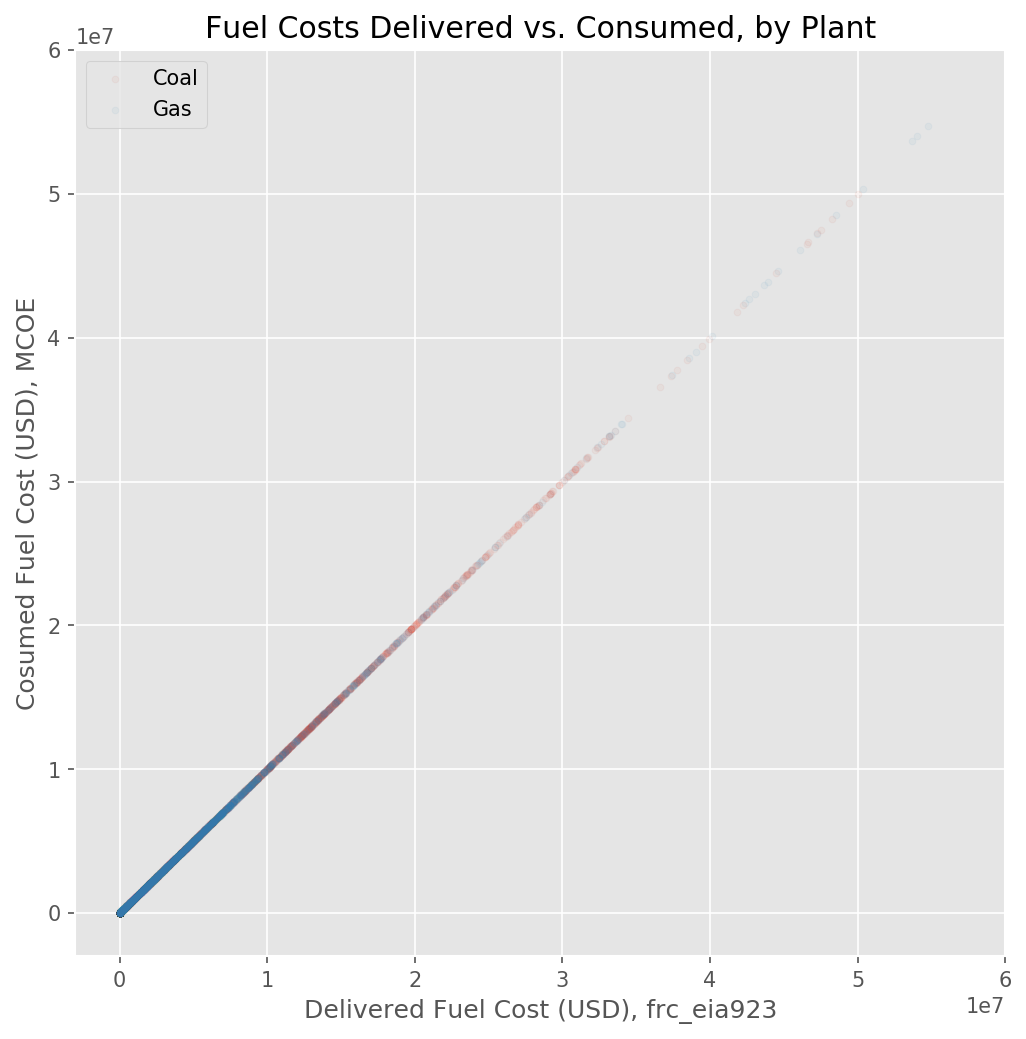

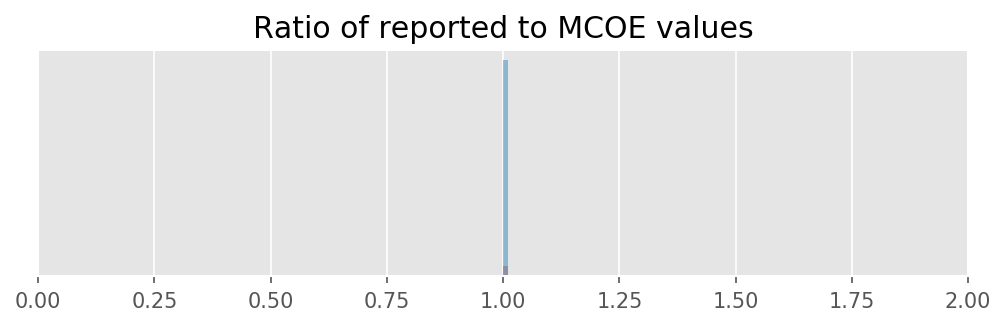

In [21]:
years = [2009,2010,2011,2012,2013,2014,2015,2016]
#years = [2015,2016]

before = frc_eia923_cg.groupby(['report_date', 'plant_id_eia', 'fuel_type_pudl'])['total_fuel_cost'].sum().reset_index()
before = before[before.report_date.dt.year.isin(years)]

after = mcoe_cg.groupby(['report_date', 'plant_id_eia', 'fuel_type_pudl'])['total_fuel_cost'].sum().reset_index()
after = after[after.report_date.dt.year.isin(years)]

cost_compare= pd.merge(
    before[['report_date','plant_id_eia','total_fuel_cost','fuel_type_pudl']],
    after[['report_date','plant_id_eia','total_fuel_cost','fuel_type_pudl']],
    on=['report_date','plant_id_eia','fuel_type_pudl'],
    suffixes=['_eia923','_mcoe'],
    validate='one_to_one'
)

mcoe_corr([cost_compare[cost_compare.fuel_type_pudl=='coal'].total_fuel_cost_eia923,
           cost_compare[cost_compare.fuel_type_pudl=='gas'].total_fuel_cost_mcoe],
          [cost_compare[cost_compare.fuel_type_pudl=='coal'].total_fuel_cost_eia923,
           cost_compare[cost_compare.fuel_type_pudl=='gas'].total_fuel_cost_mcoe],
          x_max=6e7, y_max=6e7, r_max=2, alpha=0.05, s=10, loghist=True,
          xlabel='Delivered Fuel Cost (USD), frc_eia923',
          ylabel='Cosumed Fuel Cost (USD), MCOE',
          title='Fuel Costs Delivered vs. Consumed, by Plant',
          labels=['Coal','Gas'])

In [28]:
mcoe_out.columns.tolist()

['report_date',
 'plant_id_eia',
 'plant_id_pudl',
 'unit_id_pudl',
 'generator_id',
 'plant_name',
 'operator_id',
 'util_id_pudl',
 'operator_name',
 'associated_combined_heat_power',
 'capacity_factor',
 'carbon_capture',
 'cofire_fuels',
 'county',
 'current_planned_operating_date',
 'deliver_power_transgrid',
 'duct_burners',
 'energy_source_1',
 'energy_source_2',
 'energy_source_3',
 'energy_source_4',
 'energy_source_5',
 'energy_source_6',
 'fluidized_bed_tech',
 'fuel_cost_per_mmbtu',
 'fuel_cost_per_mwh',
 'fuel_type_count',
 'fuel_type_pudl',
 'heat_bypass_recovery',
 'heat_rate_mmbtu_mwh',
 'latitude',
 'longitude',
 'minimum_load_mw',
 'multiple_fuels',
 'nameplate_capacity_mw',
 'nameplate_power_factor',
 'net_generation_mwh',
 'operating_date',
 'operating_switch',
 'original_planned_operating_date',
 'other_combustion_tech',
 'other_modifications_date',
 'other_planned_modifications',
 'ownership',
 'planned_derate_date',
 'planned_energy_source_1',
 'planned_modificat

In [32]:
mcoe_simple_cols = [
    'report_date',
    'plant_id_eia',
    'plant_id_pudl',
    'unit_id_pudl',
    'generator_id',
    'plant_name',
    'operator_id',
    'util_id_pudl',
    'operator_name',
    'county',
    'state',
    'capacity_factor',
    'fuel_cost_per_mmbtu',
    'fuel_cost_per_mwh',
    'fuel_type_pudl',
    'net_generation_mwh',
    'heat_rate_mmbtu_mwh',
    'latitude',
    'longitude',
    'minimum_load_mw',
    'prime_mover',
    'retirement_date',
    'nameplate_capacity_mw',
    'status',
    'technology',
    'summer_capacity_mw',
    'time_cold_shutdown_full_load',
    'total_fuel_cost',
    'total_mmbtu',
    'winter_capacity_mw',
]

In [47]:
plants_of_interest = [
    8223, # Springerville
    6021, # Craig
    6204, # Laramie River
    87, # Escalante
    527, # Nucla
    2541, # San Juan
]

In [48]:
tristate_mcoe = mcoe_out[(mcoe_out.operator_id==30151) | (mcoe_out.plant_id_eia.isin(plants_of_interest))][mcoe_simple_cols]

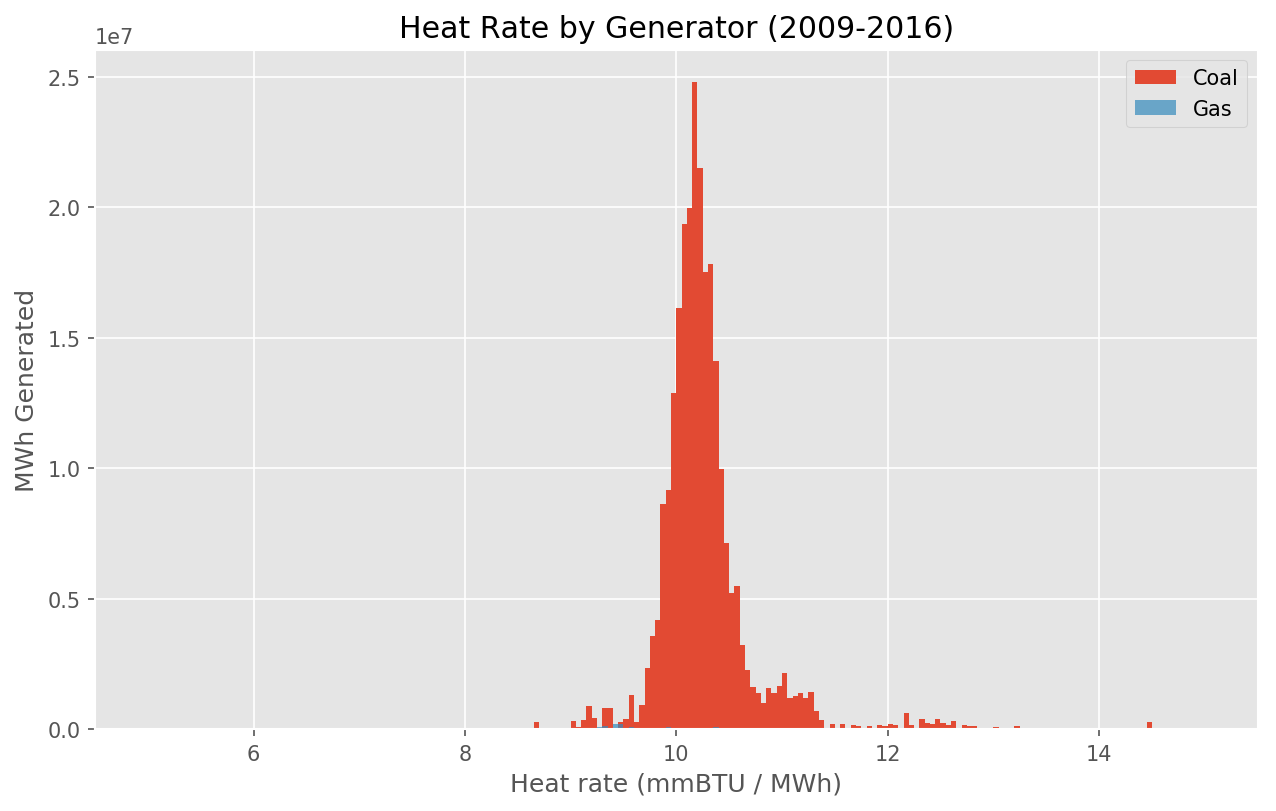

In [51]:
hr_hist(tristate_mcoe, start_date=start_date, end_date=end_date)

In [52]:
tristate_mcoe

,report_date,plant_id_eia,plant_id_pudl,unit_id_pudl,generator_id,plant_name,operator_id,util_id_pudl,operator_name,county,state,capacity_factor,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_pudl,net_generation_mwh,heat_rate_mmbtu_mwh,latitude,longitude,minimum_load_mw,prime_mover,retirement_date,nameplate_capacity_mw,status,technology,summer_capacity_mw,time_cold_shutdown_full_load,total_fuel_cost,total_mmbtu,winter_capacity_mw
4116,2009-01-01,87,1327,1,1,Escalante,30151,3515,"Tri-State G & T Assn, Inc",McKinley,NM,0.842371,1.444692,15.666461,coal,161068.0,10.844150,NaN,NaN,NaN,ST,None,257.0,existing,None,247.0,None,2.523366e+06,1.746646e+06,247.0
4117,2009-02-01,87,1327,1,1,Escalante,30151,3515,"Tri-State G & T Assn, Inc",McKinley,NM,0.796426,1.502315,16.187215,coal,137546.0,10.774848,NaN,NaN,NaN,ST,None,257.0,existing,None,247.0,None,2.226487e+06,1.482037e+06,247.0
4118,2009-03-01,87,1327,1,1,Escalante,30151,3515,"Tri-State G & T Assn, Inc",McKinley,NM,0.817100,1.494525,15.954586,coal,156236.0,10.675353,NaN,NaN,NaN,ST,None,257.0,existing,None,247.0,None,2.492681e+06,1.667874e+06,247.0
4119,2009-04-01,87,1327,1,1,Escalante,30151,3515,"Tri-State G & T Assn, Inc",McKinley,NM,0.837100,1.535660,16.520319,coal,154897.0,10.757797,NaN,NaN,NaN,ST,None,257.0,existing,None,247.0,None,2.558948e+06,1.666351e+06,247.0
4120,2009-05-01,87,1327,1,1,Escalante,30151,3515,"Tri-State G & T Assn, Inc",McKinley,NM,0.833333,1.493491,16.291428,coal,159340.0,10.908284,NaN,NaN,NaN,ST,None,257.0,existing,None,247.0,None,2.595876e+06,1.738126e+06,247.0
4121,2009-06-01,87,1327,1,1,Escalante,30151,3515,"Tri-State G & T Assn, Inc",McKinley,NM,0.809528,1.402447,15.396697,coal,149795.0,10.978455,NaN,NaN,NaN,ST,None,257.0,existing,None,247.0,None,2.306348e+06,1.644518e+06,247.0
4122,2009-07-01,87,1327,1,1,Escalante,30151,3515,"Tri-State G & T Assn, Inc",McKinley,NM,0.803889,1.407146,15.848205,coal,153710.0,11.262658,NaN,NaN,NaN,ST,None,257.0,existing,None,247.0,None,2.436028e+06,1.731183e+06,247.0
4123,2009-08-01,87,1327,1,1,Escalante,30151,3515,"Tri-State G & T Assn, Inc",McKinley,NM,0.830352,1.454392,16.385693,coal,158770.0,11.266352,NaN,NaN,NaN,ST,None,257.0,existing,None,247.0,None,2.601557e+06,1.788759e+06,247.0
4124,2009-09-01,87,1327,1,1,Escalante,30151,3515,"Tri-State G & T Assn, Inc",McKinley,NM,0.757280,1.435963,16.291684,coal,140127.0,11.345474,NaN,NaN,NaN,ST,None,257.0,existing,None,247.0,None,2.282905e+06,1.589807e+06,247.0
4125,2009-10-01,87,1327,1,1,Escalante,30151,3515,"Tri-State G & T Assn, Inc",McKinley,NM,0.821289,1.461275,16.288076,coal,157037.0,11.146484,NaN,NaN,NaN,ST,None,257.0,existing,None,247.0,None,2.557831e+06,1.750410e+06,247.0


In [53]:
tristate_mcoe.to_csv('TriState_CostByGenerator.csv')

In [59]:
len(pudl_out.gens_eia860())

186584

In [61]:
pudl_out.frc_eia923().sample(10)

,report_date,plant_id_eia,plant_id_pudl,plant_name,operator_id,util_id_pudl,operator_name,ash_content_pct,fuel_cost_per_mmbtu,fuel_quantity,fuel_type_pudl,heat_content_mmbtu_per_unit,mercury_content_ppm,sulfur_content_pct,total_fuel_cost,total_heat_content_mmbtu
98279,2009-11-01,10620,3345,Carthage Energy LLC,3085,802,Carthage Energy LLC,0.000000,NaN,9951.0,gas,1.003140,NaN,0.000000,NaN,9982.244
119289,2011-08-01,55099,4410,NRG Sterlington Power,13886,2701,NRG Sterlington Power LLC,0.000000,NaN,1416.0,gas,1.030000,NaN,0.000000,NaN,1458.480
4345,2014-05-01,165,1354,GREC,7490,1913,Grand River Dam Authority,0.000000,4.890000,54091.0,gas,1.040000,0.0,0.000000,2.750852e+05,56254.640
58152,2013-04-01,3504,2368,Stryker Creek,55983,2329,Luminant Generation Company LLC,0.000000,NaN,133196.0,gas,1.014000,NaN,0.000000,NaN,135060.744
75176,2009-07-01,6195,2574,John Twitty Energy Center,17833,1265,City Utilities of Springfield - (MO),4.985147,2.247603,58642.0,coal,17.693406,NaN,0.284257,2.332061e+06,1037576.724
28848,2015-05-01,1571,1843,Chalk Point LLC,12628,2672,NRG Chalk Point LLC,7.806187,NaN,66316.0,coal,26.123641,0.0,2.650343,NaN,1732415.360
146891,2015-02-01,57037,5466,Kemper County IGCC Project,12686,190,Mississippi Power Co,0.000000,2.960000,2449478.0,gas,1.048000,0.0,0.000000,7.598477e+06,2567052.944
69426,2012-04-01,6074,235,Greenwood,56211,161,KCP&L Greater Missouri Operations Co,0.000000,2.009000,33391.0,gas,1.000000,0.0,0.000000,6.708252e+04,33391.000
33475,2010-05-01,1877,1912,George Johnson,20910,369,Wolverine Power Supply Coop,0.000000,6.752000,20900.0,gas,1.024000,NaN,0.000000,1.445036e+05,21401.600
94416,2016-05-01,10208,3175,Escanaba Mill,55867,3661,Verso Escanaba LLC,0.000000,NaN,482343.0,gas,1.000000,0.0,0.000000,NaN,482343.000


ProgrammingError: (psycopg2.ProgrammingError) column coalmine_eia923.name does not exist
LINE 1: SELECT coalmine_eia923.id, coalmine_eia923.name, coalmine_ei...
                                   ^
 [SQL: 'SELECT coalmine_eia923.id, coalmine_eia923.name, coalmine_eia923.mine_type, coalmine_eia923.state, coalmine_eia923.county_fips_id, coalmine_eia923.mine_id \nFROM coalmine_eia923']